# Path finding for a Multi-Order Picking Robot in a Distribution Center with a crowded area using Single-Agent Q-Learning, Multi-Agent Q-Learning (MAQL) and MAQL-GA 

Consider an e-commerce company has a distribution center, and the company would like all of the picking operations in the center to be performed by warehouse robots.
* In the context of e-commerce warehousing, “picking” is the task of gathering individual items from various locations in the warehouse in order to fulfill customer orders.

After picking items from the shelves, the robots must bring the items to a specific location within the warehouse where the items can be packaged for shipping (starting point).

In order to ensure maximum efficiency and productivity, the robot will need to learn the shortest path between the item packaging area and all other locations within the warehouse where the robot is allowed to travel.

#### Import Required Libraries

In [196]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import Image
import random
from tqdm import tqdm

### Creating Classes
In order to implement the multi-agent approach, we converted our function based code to a class based code. We created two classes: `Environment` and `Q_Agent`. 

## Define the Environment
The environment consists of **states**, **actions**, and **rewards**. States and actions are inputs for the Q-learning AI agent, while the possible actions are the AI agent's outputs.
#### States
The states in the environment are all of the possible locations within the warehouse. Some of these locations are for storing items (**gray squares**), while other locations are aisles that the robot can use to travel throughout the warehouse (**white squares**) and (**pink squares**) are the crowded area where the robot should avoid. The **green squares** indicates the item loactions.

The gray squares are **terminal states**!


The AI agent's goal is to learn the shortest path between the item packaging area and all of the other locations in the warehouse where the robot is allowed to travel.

As shown in the image above, there are 121 possible states (locations) within the warehouse. These states are arranged in a grid containing 11 rows and 11 columns. Each location can hence be identified by its row and column index.

#### Rewards
The last component of the environment that we need to define are the **rewards**.

To help the AI agent learn, each state (location) in the warehouse is assigned a reward value.

The agent may begin at any white square, but its goal is always the same: ***to maximize its total rewards***!

Negative rewards (i.e., **punishments**) are used for all states except the goal.
* This encourages the AI to identify the *shortest path* to the goal by *minimizing its punishments*!

To maximize its cumulative rewards (by minimizing its cumulative punishments), the AI agent will need find the shortest paths between the item locations (green squares) and all of the other locations in the warehouse where the robot is allowed to travel (white squares). (pink squares) are the crowded area and it is better that the robot does not pass through this area. The agent will also need to learn to avoid crashing into any of the item storage locations (gray squares)!

### Environment Setup
We define an Environment class to create and manage the distribution center environment. This class includes methods to initialize the environment, build the rewards map, reset active rewards, check if a state is terminal, and more.

In [197]:
class Environment:
    def __init__(self, environment_rows=11, environment_columns=11, ORDER_REWARD=100,
                 TERMINAL_PENALTY=-100, STEP_PENALTY=-1, START=(1,5), reward_locs=[(8,2),(2,7),(5,4),(8,7)]):
        
        self.environment_rows = environment_rows
        self.environment_columns = environment_columns
        self.ORDER_REWARD = ORDER_REWARD
        self.TERMINAL_PENALTY = TERMINAL_PENALTY
        self.STEP_PENALTY = STEP_PENALTY
        self.START = START
        self.reward_locs = reward_locs.copy() # rewards loc is a list, which is mutable, so we need to make a copy
                                                # otherwise, the original list will be changed when we change the copy
        self.reward_locs.append(START)
        self.NUM_ORDERS = len(self.reward_locs)
        self.orders_left = self.NUM_ORDERS        

        # Call the build_environment function to initialize rewards
        self.REWARDS_MAP = self.build_environment(self.reward_locs.copy()) # map of rewards that will not be updated, used for plotting
        self.active_rewrads = self.REWARDS_MAP.copy() # copy of rewards map that will be updated as orders are completed
        

    def build_environment(self, reward_locs):
        """Builds the rewards map based on the given reward locations"""
        # Create a 2D numpy array to hold the rewards for each state.
        rewards = np.full((self.environment_rows, self.environment_columns), self.TERMINAL_PENALTY)

        # Define aisle locations (i.e., white squares) for rows 1 through 9
        aisles = {}
        aisles[0] = []
        aisles[1] = [i for i in range(1, 10)]
        aisles[2] = [1, 5, 9]
        aisles[3] = [1, 5, 9]
        aisles[4] = [i for i in range(1, 10)]
        aisles[5] = [1, 5, 9]
        aisles[6] = [i for i in range(1, 10)]
        aisles[7] = [1, 5, 9]
        aisles[8] = [1, 5, 9]
        aisles[9] = [i for i in range(1, 10)]
        aisles[10] = []

        # Set the rewards for all aisle locations (i.e., white squares)
        for row_index in range(0, 11):
            for column_index in aisles[row_index]:
                rewards[row_index, column_index] = self.STEP_PENALTY

        # Set the reward for the packaging area (i.e., the goal) to ORDER_REWARD
        for loc in reward_locs[:-1]:
            rewards[loc[0], loc[1]] = self.ORDER_REWARD
        
        # Set the rewards for crowded locations (i.e., pink squares)
        rewards[4, 5] = -10
        rewards[5, 5] = -50
        rewards[6, 5] = -10
        
        
        
        return rewards

    def reset_active_rewards(self):
        """Resets the active rewards map to the original rewards map, and resets the number of orders left"""
        self.active_rewrads = self.REWARDS_MAP.copy()
        self.orders_left = self.NUM_ORDERS    
        
    def is_terminal_state(self, current_row_index, current_column_index):
        if self.active_rewrads[current_row_index, current_column_index] == self.TERMINAL_PENALTY:
            return True
        else:
            return False
    
    def is_order_state(self, current_row_index, current_column_index, alter_rewards=True):
        """Returns True if the current state is an order state, False otherwise
        
        Also removes the order from the active rewards map, and updates the number of orders left
        
        """

        if self.active_rewrads[current_row_index, current_column_index] == self.ORDER_REWARD:
            if alter_rewards:
                self.active_rewrads[current_row_index, current_column_index] = self.STEP_PENALTY
                self.orders_left -= 1
                #print("Order completed! Orders left: ", self.orders_left)
                if self.orders_left == 1:
                    self.active_rewrads[self.START[0], self.START[1]] = self.ORDER_REWARD
                return True
            else:
                return True
        else:
            return False
    
    
    def get_starting_location(self):
        '''Returns the starting location for the agent in the environment'''
        return self.START[0], self.START[1]
        


#### define the shape of the environment (i.e., its states)

In [198]:
environment_rows = 11
environment_columns = 11
ORDER_REWARD = 100
TERMINAL_PENALTY = -100
STEP_PENALTY = -1
START = (1,5)
reward_locs = [(8,2),(2,7),(5,4),(8,7)]


## Initialize the Environment class

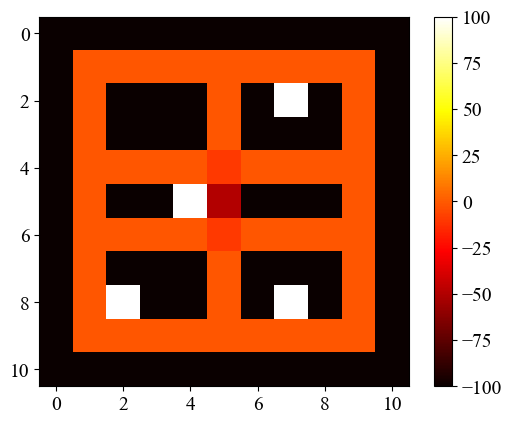

In [199]:
env = Environment(environment_rows, environment_columns, ORDER_REWARD, TERMINAL_PENALTY, STEP_PENALTY, START, reward_locs)

# You can access the rewards array using env.rewards
plt.imshow(env.REWARDS_MAP, cmap='hot', interpolation='nearest')
plt.colorbar()

In [200]:
env.NUM_ORDERS

5

In [201]:
env.reward_locs


[(8, 2), (2, 7), (5, 4), (8, 7), (1, 5)]

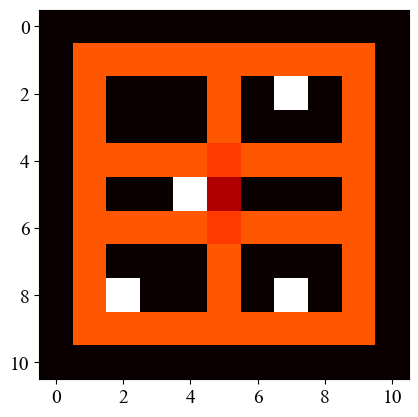

In [202]:
# You can access the rewards array using env.rewards
plt.imshow(env.active_rewrads, cmap='hot', interpolation='nearest')

### Visualize the rewards map

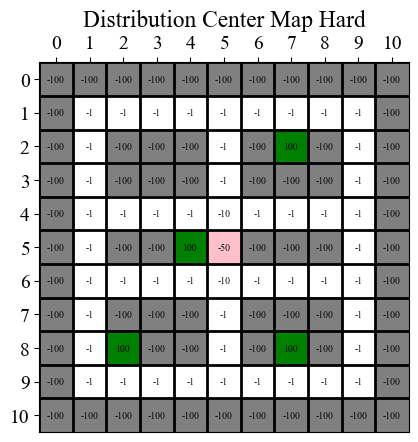

In [203]:
plt.figure()
colormap = colors.ListedColormap(["gray","pink","white","black","green"])
im = plt.imshow(env.active_rewrads, cmap= colormap)

ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 11, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, 11, 1))
ax.set_yticklabels(np.arange(0, 11, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Let the horizontal axes labeling appear on top.
ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

for i in range(0,11):
    for j in range(0,11):
        text = ax.text(j, i, env.active_rewrads[i, j],
                       ha="center", va="center", color="black", fontsize=7)

# Gridlines based on minor ticks
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)


ax.set_title("Distribution Center Map Hard")
plt.show()
# plt.savefig('Distribution-Center-Map-Hard.jpg')

In [204]:
env.is_order_state(8,2) 

True

In [205]:
env.reset_active_rewards()

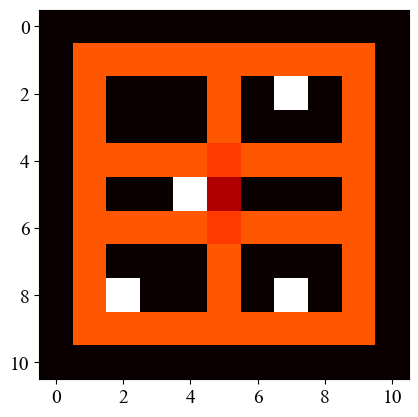

In [206]:
# You can access the rewards array using env.rewards
plt.imshow(env.active_rewrads, cmap='hot', interpolation='nearest')

In [207]:
env.is_terminal_state(1,1)

False

In [208]:
(np.random.random((4,4)) * 2 - 1) /10

array([[ 0.06285245,  0.07077047,  0.02817376,  0.03138641],
       [-0.09140124, -0.01892234, -0.07497422,  0.03609413],
       [ 0.05542962, -0.07801268,  0.01581386,  0.00947608],
       [-0.02283381,  0.05275188,  0.01634859,  0.09058131]])

## Train the Model
Our next task is for our AI agent to learn about its environment by implementing a Q-learning model.

#### Actions
The actions that are available to the AI agent are to move the robot in one of four directions:
* Up
* Right
* Down
* Left

## Q-Learning Agent
We define a QLearningAgent class for the robot's Q-learning. This class handles the agent's initialization, action selection, state transition, and Q-value updates.

In [209]:
import numpy as np
from typing import Any, Type
from tqdm import tqdm

class QLearningAgent:
    def __init__(self,environment_rows=11, environment_columns=11,ORDER_REWARD=100, TERMINAL_PENALTY=-100,
                 STEP_PENALTY=-1, START=(1,5), reward_locs=[(8,2),(2,7),(5,4),(8,7)],actions=('up', 'right', 'down', 'left')):
        
        self.env = Environment(environment_rows, environment_columns,ORDER_REWARD, TERMINAL_PENALTY, STEP_PENALTY, START, reward_locs.copy())
        # Initialize the Q-values to random numbers between -0.1 and 0.1
        self.q_values = np.random.random((self.env.NUM_ORDERS, environment_rows, environment_columns, 4)) * 2 - 1
        self.q_values = self.q_values / 10
        self.environment_rows = environment_rows
        self.environment_columns = environment_columns
        self.actions = actions


    def get_next_action(self, current_row_index, current_column_index, epsilon, order_number):
        if np.random.random() < epsilon:
            return np.argmax(self.q_values[order_number, current_row_index, current_column_index])
        else:
            return np.random.randint(4)

    def get_next_location(self, current_row_index, current_column_index, action_index):
        new_row_index = current_row_index
        new_column_index = current_column_index
        if self.actions[action_index] == 'up' and current_row_index > 0:
            new_row_index -= 1
        elif self.actions[action_index] == 'right' and current_column_index < self.environment_columns - 1:
            new_column_index += 1
        elif self.actions[action_index] == 'down' and current_row_index < self.environment_rows - 1:
            new_row_index += 1
        elif self.actions[action_index] == 'left' and current_column_index > 0:
            new_column_index -= 1
        else:
            raise Exception(f"Invalid action {action_index}")
        return new_row_index, new_column_index
    
    def get_shortest_path(self, verbose=True):
        self.env.reset_active_rewards()
        shortest_path = []
        reward_sum = 0
        if self.env.is_terminal_state(self.env.START[0], self.env.START[1]) or self.env.is_order_state(self.env.START[0], self.env.START[1], alter_rewards=False):
            print(f"START: {self.env.START} | Terminal State: {self.env.is_terminal_state(self.env.START[0], self.env.START[1])} | Order State: {self.env.is_order_state(self.env.START[0], self.env.START[1], alter_rewards=False)}")
            print(f"Rwards: {self.env.active_rewrads[self.env.START[0], self.env.START[1]]}")
            raise Exception("The starting location cannot be a terminal state or an order state!")
        current_row_index, current_column_index = self.env.get_starting_location()
        shortest_path.append((current_row_index, current_column_index))
        reward_sum += self.env.active_rewrads[current_row_index, current_column_index]
        while not self.env.is_terminal_state(current_row_index, current_column_index) and self.env.orders_left > 0:
            order_number = self.env.NUM_ORDERS - self.env.orders_left # order number is the number of orders completed so far which is the index of the current order and defines the q_values layer to use
            action_index = self.get_next_action(current_row_index, current_column_index,1.0, order_number)
            current_row_index, current_column_index = self.get_next_location(current_row_index, current_column_index, action_index)
            shortest_path.append((current_row_index, current_column_index))
            reward_sum += self.env.active_rewrads[current_row_index, current_column_index]
            self.env.is_order_state(current_row_index, current_column_index) # this will remove the order from the active rewards map
            
            if len(shortest_path) > 500:
                if verbose:
                    print("Infinite loop! Something is wrong")
                break
        return shortest_path, reward_sum
    
    def fitness_score(self, verbose=False):
        shortest_path, reward_sum = self.get_shortest_path(verbose=verbose)
        return reward_sum
    
    def train(self, num_episodes, epsilon, discount_factor, learning_rate, change_w_gamma=False, verbose = True):
        """ Train the Q-learning agent
        Inputs:
            num_episodes: Number of episodes to use for training
            epsilon: The probability of choosing a random action (between 0 and 1)
            discount_factor: Discount factor for future rewards
            learning_rate: The step size to use for updating the Q-values
            change_w_gamma: If True, the learning rate and epsilon will change with gamma throughout training (default False)
        returns:
            episode_rewards_list: List containing the rewards obtained in each episode during training
        """
        self.env.reset_active_rewards()
        gamma = 1-(1 / (num_episodes/2))
        progress_bar = tqdm(range(num_episodes), desc="Training Progress", unit="Episode", disable=not verbose)
        self.zero_order_hit_count = 0
        one_order_hit_count = 0
        episode_rewards_list = []
        for episode in progress_bar:
            self.env.reset_active_rewards()
            episode_rewards_sum = 0
            row_index, column_index = self.env.get_starting_location()
            
            while not self.env.is_terminal_state(row_index, column_index) and self.env.orders_left > 0:
                order_number = self.env.NUM_ORDERS - self.env.orders_left
                action_index = self.get_next_action(row_index, column_index,epsilon, order_number=order_number)
                
                old_row_index, old_column_index = row_index, column_index # store the old row and column indexes
                row_index, column_index = self.get_next_location(row_index, column_index, action_index)
                
                reward = self.env.active_rewrads[row_index, column_index]
                episode_rewards_sum += reward
                
                old_q_value = self.q_values[order_number, old_row_index, old_column_index, action_index]
                temporal_difference = reward + (discount_factor * np.max(self.q_values[order_number, row_index, column_index])) - old_q_value
                new_q_value = old_q_value + (learning_rate * temporal_difference)
                self.q_values[order_number, old_row_index, old_column_index, action_index] = new_q_value
                
                if self.env.is_order_state(row_index, column_index):
                    if self.env.orders_left == 0:
                        self.zero_order_hit_count += 1
                    elif self.env.orders_left == 1:
                        one_order_hit_count += 1
                
            episode_rewards_list.append(episode_rewards_sum)
            
            if change_w_gamma:
                learning_rate = max(learning_rate * gamma, 0.01)
                epsilon = min(epsilon * (2-gamma), 0.9)

            progress_bar.set_postfix({"Ord left": self.env.orders_left, "lr": learning_rate, "Eps": epsilon,
                                      "0 Order":self.zero_order_hit_count, "1 Order":one_order_hit_count})
        
        progress_bar.close()
        return episode_rewards_list
            
        



## Initialize the Q-learning agent
We initialize the Q-learning agent and perform training:

In [210]:
agent = QLearningAgent(environment_rows, environment_columns, ORDER_REWARD, TERMINAL_PENALTY, STEP_PENALTY, START, reward_locs)
agent.q_values.shape

(5, 11, 11, 4)

In [211]:
reward_per_episode_list = agent.train(num_episodes=10000, epsilon=0.9, discount_factor=0.9, learning_rate=0.9, verbose=True)

Training Progress: 100%|██████████| 10000/10000 [00:07<00:00, 1358.36Episode/s, Ord left=3, lr=0.9, Eps=0.9, 0 Order=983, 1 Order=2173]


In [212]:
agent.fitness_score()

458

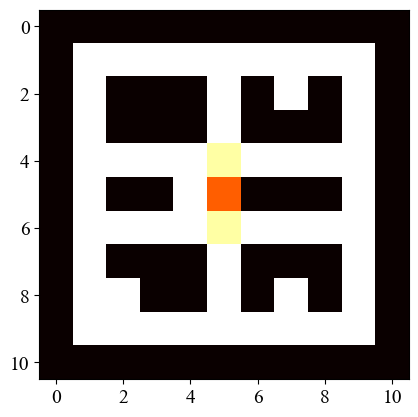

In [213]:
plt.imshow(agent.env.active_rewrads, cmap='hot', interpolation='nearest')

In [214]:
agent.env.ORDER_REWARD

100

In [215]:
shortest_path = agent.get_shortest_path()

In [216]:
print("Path: ",shortest_path[0], "\nRewardSum: ", shortest_path[1])

Path:  [(1, 5), (1, 6), (1, 7), (2, 7), (1, 7), (1, 6), (1, 5), (1, 4), (1, 3), (1, 2), (1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (4, 3), (4, 4), (5, 4), (6, 4), (6, 3), (6, 2), (6, 1), (7, 1), (8, 1), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (8, 7), (9, 7), (9, 8), (9, 9), (8, 9), (7, 9), (6, 9), (5, 9), (4, 9), (3, 9), (2, 9), (1, 9), (1, 8), (1, 7), (1, 6), (1, 5)] 
RewardSum:  458


## Genetic Training for QLGA
Each agent has its own Q-Table and is trying to find the optimal path. These agents share their Q-Tables with each other, through a Genetic Algorithm. After a certain number of episodes, `E`, we combine the Q-Tables of the agents and use the `Genetic Algorithm`.
We define a GeneticTraining class to perform genetic training for Q-learning agents. This class handles the genetic algorithm operations, including selection, crossover, and mutation.

In [217]:
class GeneticTraining:
    def __init__(self, population=10, num_episodes=1000, epsilon=0.9, discount_factor=0.9, learning_rate=0.1):
        self.population = population
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.agents = [QLearningAgent() for _ in range(population)]
        self.agent_q_table_shape = self.agents[0].q_values.shape
        self.best_agent = None
        self.best_reward = -10000 # initialize with a very low value so that the first agent will be the best
        self.best_agent_index = None
        self.best_agent_shortest_path = None
        self.best_reward_history = []
    
    def agents_fitness_score(self, agents):
        fitness_list = [agent.fitness_score() for agent in agents]
        return fitness_list.copy()
    
    def selection(self, agents):
        """commonly known as roulette wheel selection or fitness-proportionate selection
        in a genetic algorithm. It is a way to select individuals from a population with
        a probability that is proportional to their fitness scores."""
        fitness_list = self.agents_fitness_score(agents)
        fitness_array = np.array(fitness_list, dtype=np.float64)
        if np.min(fitness_array) < 0: # to avoid negative fitness values, which consequently will cause negative probabilities.
            fitness_array -= (np.min(fitness_array) * 2)
            
        if np.sum(fitness_array) == 0:
            fitness_array += 0.001
        normalized_probabilities = fitness_array / (np.sum(fitness_array)) # add a small value to avoid zero probabilities
        parents = np.random.choice(agents, size=2, replace=False, p=normalized_probabilities)
        return parents
    
    def crossover(self, parents, mean_parents = True)-> QLearningAgent:
        child = QLearningAgent()
        if mean_parents:
            child.q_values = (parents[0].q_values + parents[1].q_values) / 2
        else:
            crossover_point = np.random.randint(2, size = self.agent_q_table_shape[:-1])
            crossover_point = np.stack([crossover_point] * self.agent_q_table_shape[-1], axis=-1)
            child_q_values = np.where(crossover_point == 1, parents[0].q_values, parents[1].q_values)
            child.q_values = child_q_values
        return child
    
    def mutation(self, child: Type[QLearningAgent], mutation_prob=0.2)-> QLearningAgent:
        mutation_point = np.random.choice([0,1], size = self.agent_q_table_shape[:-1], p=[1-mutation_prob, mutation_prob])
        mutation_point = np.stack([mutation_point] * self.agent_q_table_shape[-1], axis=-1)
        
        max_gene_value = np.max(child.q_values)
        min_gene_value = np.min(child.q_values)
        
        # print(f"max_gene_value: {max_gene_value} | min_gene_value: {min_gene_value}")
        
        mutation_value = np.random.uniform(low=min_gene_value, high=max_gene_value, size=self.agent_q_table_shape)
        child.q_values = np.where(mutation_point == 1, mutation_value, child.q_values)
        return child
    
    def genetic_algorithm(self, agents_list, parents_to_keep_ratio=0.5, mutation_prob=0.0):
        agents_list = sorted(agents_list, key=lambda agent: agent.fitness_score(), reverse=True)
        num_parents_to_keep = int(len(agents_list) * parents_to_keep_ratio)
        num_childs_to_create = len(agents_list) - num_parents_to_keep
        childs_list = []
        for _ in range(num_childs_to_create):
            parents = self.selection(agents_list)
            child = self.crossover(parents)
            if mutation_prob > 0.0:
                child = self.mutation(child, mutation_prob)
            childs_list.append(child)
            
        agents_list = agents_list[:num_parents_to_keep] + childs_list
        
        return agents_list
        
    
    
    def train(self, episodes = 500, q_learning_episodes = 10, use_genetic_algorithm=True):
        if episodes % q_learning_episodes != 0:
            raise Exception("episodes must be divisible by q_learning_step")
        # call the .tarin() method of each agent for q_learning_step times
        steps = episodes // q_learning_episodes
        progress_bar = tqdm(range(steps), desc="Training Progress", unit="Step")
        for step in progress_bar:
            for agent in self.agents:
                agent.train(num_episodes=q_learning_episodes, epsilon=self.epsilon,
                            discount_factor=self.discount_factor, learning_rate=self.learning_rate, verbose=False)
            if use_genetic_algorithm:    
                self.agents = self.genetic_algorithm(self.agents)
            
            fitness_list = self.agents_fitness_score(self.agents)
            best_agent_index = np.argmax(fitness_list)
            best_in_list = fitness_list[best_agent_index]
            if self.best_reward < best_in_list:
                self.best_reward = best_in_list
                self.best_agent = self.agents[best_agent_index]
                self.best_reward_history.append((step, self.best_reward))
            
                progress_bar.set_postfix({"(Step, Best Reward)": (step,self.best_reward)})
        

        

## Initialize genetic training
We initialize genetic training and perform training:

In [218]:
gt = GeneticTraining(population=20)
gt.train(episodes=1000, q_learning_episodes=10, use_genetic_algorithm=True)

Training Progress: 100%|██████████| 100/100 [00:53<00:00,  1.87Step/s, (Step, Best Reward)=(98, 455)]


## Get Shortest Path

In [219]:
print(gt.best_agent.get_shortest_path())

Infinite loop! Something is wrong
([(1, 5), (1, 6), (1, 7), (2, 7), (1, 7), (1, 6), (1, 5), (2, 5), (3, 5), (4, 5), (4, 4), (5, 4), (6, 4), (6, 3), (6, 2), (6, 1), (7, 1), (8, 1), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 7), (8, 7), (9, 

In [220]:
gt.best_reward_history

[(0, -3), (17, 79), (21, 84), (27, 173), (36, 266), (37, 267), (98, 455)]

In [221]:
from scipy.interpolate import interp1d

def interpolate_points(points, min_x, max_x, only_y=True):
    points = points.copy()
    x, y = zip(*points)
    f = interp1d(x, y, bounds_error=False, fill_value=None)
    x_new = range(min_x, max_x)
    y_new = f(x_new)
    if only_y:
        return [y if y is not None else None for y in y_new]
    else:
        return [(x, y) if y is not None else (x, None) for x, y in zip(x_new, y_new)]

## Cross-Validation and Plotting
We perform cross-validation to assess the performance of the trained agents and plot the results:

In [222]:
def cross_val(num_cross_val = 10,population=10, num_episodes=1000, q_learning_episodes=10, use_genetic_algorithm=True):
    best_reward_history_list = []
    for i in range(num_cross_val):
        print(f"Cross Validation {i+1} of {num_cross_val}")
        gt = None
        gt = GeneticTraining(population=population)
        gt.train(episodes=num_episodes, q_learning_episodes=q_learning_episodes, use_genetic_algorithm=use_genetic_algorithm)
        # print(gt.best_reward_history[-1])
        print("\n")
        best_reward_history_interpolated = interpolate_points(gt.best_reward_history, min_x=0, max_x=num_episodes//q_learning_episodes, only_y=True)
        best_reward_history_list.append(best_reward_history_interpolated)

    
    return best_reward_history_list

In [223]:
history_single = cross_val(num_cross_val=5, population=1, num_episodes=2000, q_learning_episodes=10, use_genetic_algorithm=False)
history_multi = cross_val(num_cross_val=5, population=20, num_episodes=2000, q_learning_episodes=10, use_genetic_algorithm=False)
history_genetic = cross_val(num_cross_val=5, population=20, num_episodes=2000, q_learning_episodes=10, use_genetic_algorithm=True)

Cross Validation 1 of 5


Training Progress: 100%|██████████| 200/200 [00:01<00:00, 142.41Step/s, (Step, Best Reward)=(165, 455)]




Cross Validation 2 of 5


Training Progress: 100%|██████████| 200/200 [00:01<00:00, 150.80Step/s, (Step, Best Reward)=(141, 455)]




Cross Validation 3 of 5


Training Progress: 100%|██████████| 200/200 [00:01<00:00, 135.18Step/s, (Step, Best Reward)=(179, 458)]




Cross Validation 4 of 5


Training Progress: 100%|██████████| 200/200 [00:01<00:00, 153.25Step/s, (Step, Best Reward)=(160, 455)]




Cross Validation 5 of 5


Training Progress: 100%|██████████| 200/200 [00:01<00:00, 150.64Step/s, (Step, Best Reward)=(144, 455)]




Cross Validation 1 of 5


Training Progress: 100%|██████████| 200/200 [00:25<00:00,  7.81Step/s, (Step, Best Reward)=(119, 455)]




Cross Validation 2 of 5


Training Progress: 100%|██████████| 200/200 [00:22<00:00,  9.07Step/s, (Step, Best Reward)=(131, 462)]




Cross Validation 3 of 5


Training Progress: 100%|██████████| 200/200 [00:10<00:00, 18.36Step/s, (Step, Best Reward)=(117, 455)]




Cross Validation 4 of 5


Training Progress: 100%|██████████| 200/200 [00:20<00:00,  9.79Step/s, (Step, Best Reward)=(122, 462)]




Cross Validation 5 of 5


Training Progress: 100%|██████████| 200/200 [00:25<00:00,  7.82Step/s, (Step, Best Reward)=(115, 462)]




Cross Validation 1 of 5


Training Progress: 100%|██████████| 200/200 [02:14<00:00,  1.49Step/s, (Step, Best Reward)=(98, 455)]




Cross Validation 2 of 5


Training Progress: 100%|██████████| 200/200 [02:14<00:00,  1.48Step/s, (Step, Best Reward)=(94, 455)]




Cross Validation 3 of 5


Training Progress: 100%|██████████| 200/200 [02:19<00:00,  1.43Step/s, (Step, Best Reward)=(99, 455)]




Cross Validation 4 of 5


Training Progress: 100%|██████████| 200/200 [01:36<00:00,  2.08Step/s, (Step, Best Reward)=(97, 455)]




Cross Validation 5 of 5


Training Progress: 100%|██████████| 200/200 [00:49<00:00,  4.00Step/s, (Step, Best Reward)=(90, 455)]

In [224]:
len(history_single)
hist_array = np.array(history_single)
# hist_array


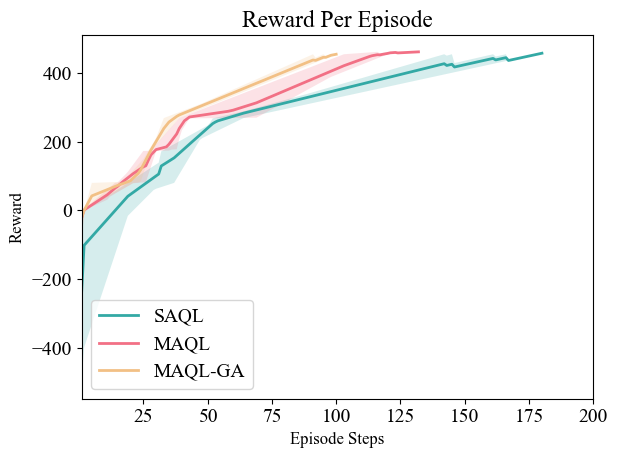

In [225]:
from plot import plot_train_test_losses
history_single_arr, history_multi_arr, history_genetic_arr = np.array(history_single), np.array(history_multi), np.array(history_genetic)

plot_train_test_losses(history_single_arr, history_multi_arr, history_genetic_arr)

# # Save history arrays for later use
# np.save("history_single.npy", history_single)
# np.save("history_multi.npy", history)
# np.save("history_genetic.npy", history2)
